<a href="https://colab.research.google.com/github/stemgene/fastai2019/blob/master/Lesson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - What's your pet
Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File->Open` now and click 00_notebook_tutorial.ipynb.

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
#Reload all modules before executing a new line. If a module is edited, it is not necessary to rerun the import commands, the modules will be reloaded automatically.
%reload_ext autoreload
%autoreload 2
# This command ensures that all matplotlib plots will be plotted in the output cell within the notebook and will be kept in the notebook when saved
%matplotlib inline 

We import all the necessary packages. We are going to work with the [fastai V1 library](https://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller batch size (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these **37** distinct categories. According to their paper, the best accuracy they could get in 2012 was **59.21%**, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [15]:
help(untar_data)  # download data automatically

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [16]:
path = untar_data(URLs.PETS)
path # since you've already untar this, the second time run path again, it won't download it again.

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [17]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
# use '/' to create some paths. '/' is a function in Python3.0
path_anno = path/'annotations'
path_img = path/'images' # a path through the images in the dataset

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves, concretely, `dictionary/label_index.jpg`. We will need to extract them to be able to classify the images into the correct categories. 

In [19]:
fnames = get_image_files(path_img)
fnames[:5]
# file's name is also the label.

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_196.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bombay_34.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/chihuahua_191.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_155.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_52.jpg')]

Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html). This object represents all of the data you need to build a model and try to make it really easy to create that ImageDataBunch, which contains training set and validation set with images and labels.

In this case, we need to extract the labels from names, we use `from_name_re`, `re` is the module in Python does regular expressions.


In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

* path_img: dictionary path of images
* fnames: list of file's name
* pat: pattern of re
* ds_tfm: transform
* size: same size 224. GPUs need to apply the exact same instruction through a whole bunch of things at the same time in order to be fast. If the size is not 224 * 224, use transference, can make size to 224

ImageDataBuch.from_name_re will return a DabaBunch object, in fastai, everything the model with is gonna be a data of bunch of object.
The data bunch of object contains 2 - 3 datasets, and for each of those it contains images or texts and labels 
or your tabular data in your labels or so. And they will put into one place (i.g. data)



In [0]:
# 224 is good for most of the time. the last layer is 7*7, so we want the input is the times of 7*2
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224) 
data.normalize(imagenet_stats) # normalization: same mean and sd

**Normalize an image**: The pixel value starts from 0-255, and 3 channels (red, green, blue). Some channels might tend to be bright and some might dark. It really helps train a deep learning model if each one of those red, green and blue channels has a mean of 0 and a sd of 1.

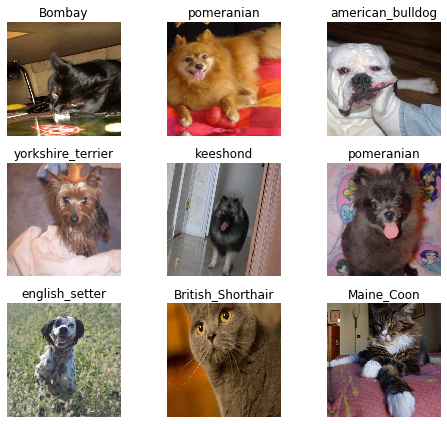

In [22]:
data.show_batch(rows=3, figsize=(7,6))

In [23]:
print(data.classes)
len(data.classes), data.c
# data.c is the number of class in classification problems.

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)